# Predicting relative humidity from the change in resistance value:

In [16]:
import pandas as pd
humidity=pd.read_csv("humidity.csv",index_col="Time")

In [17]:
null_pct=humidity.apply(pd.isnull).sum()/humidity.shape[0]
valid_columns=humidity.columns[null_pct<0.05]

In [18]:
valid_columns

Index(['RelativeHumidity', 'Temperature', 'Resistance'], dtype='object')

In [19]:
humidity.head()

,RelativeHumidity,Temperature,Resistance
Time,,,
0,20.000,25.0000,1700.00
1,20.124,25.0083,1686.12
2,20.248,25.0166,1672.24
3,20.372,25.0249,1658.36
4,20.496,25.0332,1644.48


In [20]:

humidity.columns=humidity.columns.str.lower()

In [21]:
humidity=humidity.ffill()
humidity["relativehumidity"].astype("float")
humidity["resistance"].astype("float")
humidity["temperature"].astype("float")

Time
0      25.0000
1      25.0083
2      25.0166
3      25.0249
4      25.0332
        ...   
598    29.9800
599    29.9883
600    29.9966
601    30.0049
602    30.0132
Name: temperature, Length: 605, dtype: float64

In [22]:
humidity.corr()

,relativehumidity,temperature,resistance
relativehumidity,1.000000,1.000000,-0.061629
temperature,1.000000,1.000000,-0.061629
resistance,-0.061629,-0.061629,1.000000


In [23]:
humidity["target"]=humidity.shift(-1)["relativehumidity"]
humidity=humidity.ffill()
humidity

,relativehumidity,temperature,resistance,target
Time,,,,
0,20.000,25.0000,1700.00,20.124
1,20.124,25.0083,1686.12,20.248
2,20.248,25.0166,1672.24,20.372
3,20.372,25.0249,1658.36,20.496
4,20.496,25.0332,1644.48,20.620
...,...,...,...,...
598,94.400,29.9800,200.00,94.524
599,94.524,29.9883,200.00,94.648
600,94.648,29.9966,200.00,94.772


In [24]:
from sklearn.linear_model import Ridge
rr=Ridge(alpha=0.1)
predictors=humidity.columns[~humidity.columns.isin(["target"])]

In [25]:
def backtest(humidity,model,predictors,start=20,step=90):
    all_predictions=[]
    for i in range(start, humidity.shape[0],step):
        train=humidity.iloc[:i:]
        test=humidity.iloc[i:(i+step):]
        model.fit(train[predictors],train["target"])
        preds=model.predict(test[predictors])
        preds=pd.Series(preds,index=test.index)
        combined= pd.concat([test["target"],preds,test["resistance"]],axis=1)
        combined.columns=["actual","prediction","resistance"]
        all_predictions.append(combined)
    return pd.concat(all_predictions)
predictions=backtest(humidity,rr,predictors)
predictions


,actual,prediction,resistance
Time,,,
20,22.604,22.603999,1422.40
21,22.728,22.727999,1408.52
22,22.852,22.851999,1394.64
23,22.976,22.975999,1380.76
24,23.100,23.099999,1366.88
...,...,...,...
598,94.524,94.523982,200.00
599,94.648,94.647982,200.00
600,94.772,94.771982,200.00


In [26]:
#Calculating mean absolute error
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predictions["actual"],predictions["prediction"])


0.9123371213301293

In [49]:
#calculting accuracy
from sklearn.metrics import accuracy_score
l=list(predictions["actual"])
actual=[]
pred=[]
for i in l:
    i=int(i)
    actual.append(i)
m=list(predictions["prediction"])
for i in m:
    i=int(i)
    pred.append(i)
accuracy = accuracy_score(actual,pred)
print(accuracy)

0.8752136752136752


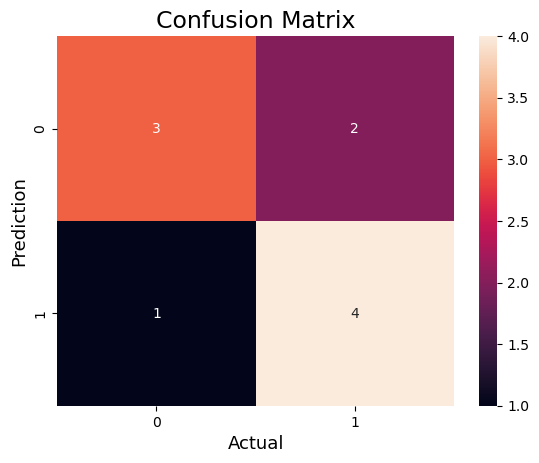

In [57]:
#plotting confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(actual,pred)

import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cm,
            annot=True,
            fmt='g',)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()


In [59]:
#Root mean square error:
import numpy as np
from sklearn.metrics import mean_squared_error

# Calculate RMSE
mse=mean_squared_error(l,m)
rmse = np.sqrt(mean_squared_error(l,m))

print("Root Mean Square Error:", rmse)
print("mean square error:",mse)

Root Mean Square Error: 2.8735637944532684
mean square error: 8.257368880792665


In [ ]:
res=float(input("Enter the resistance value"))

filter = predictions["resistance"]==res
x=0
for i in (predictions["resistance"]==res):
    if i==True:
        x+=1
if x>0:
    prediction=predictions.where(filter,inplace=True)
else:
    min=200
    for i in predictions["resistance"]:
        if abs(i-res)<min:
            min=i
    filter = predictions["resistance"]==min
    prediction=predictions.where(filter,inplace=True)
print(predictions)
print(predictions["prediction"].mean())
print(predictions["resistance"].mean())

      actual  prediction  resistance
Time                                
20       NaN         NaN         NaN
21       NaN         NaN         NaN
22       NaN         NaN         NaN
23       NaN         NaN         NaN
24       NaN         NaN         NaN
...      ...         ...         ...
598   94.524   94.523982       200.0
599   94.648   94.647982       200.0
600   94.772   94.771982       200.0
601   94.896   94.895982       200.0
602   94.896   95.019982       200.0

[585 rows x 3 columns]
61.23114883808859
200.0
